In [ ]:
!pip install tensorflow 
!pip install tensorflow-hub
!pip install tensorflow-datasets

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
from tensorflow . keras import Sequential
from tensorflow . keras . layers import Layer
from tensorflow . keras . layers import Dense
from tensorflow . keras . layers import Conv1D
from tensorflow . keras . layers import MaxPool1D
from tensorflow . keras . models import Model
from keras.layers import Flatten

In [2]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:75%]', 'train[75%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLFJ5SA/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLFJ5SA/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteLFJ5SA/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
len_train=len(list(train_data))
len_test=len(list(test_data))

In [4]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(len_train)))
valid_examples_batch, valid_labels_batch = next(iter(validation_data.batch(len_train)))
test_examples_batch, test_labels_batch = next(iter(test_data.batch(len_test)))

In [5]:
train_labels_batch.shape

TensorShape([18750])

In [6]:
#Converting to google word embedding of 50 dimension
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")
hub_layer = hub.KerasLayer(embed, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [7]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Reshape((50, 1)))


In [8]:

#Encoding
model.add(Conv1D ( input_shape=(50,1),
                   filters = 32 ,
                    kernel_size =4,
                    activation ='relu',
                   padding='same',
                   name='encoder_conv11'
                    ))
model.add(MaxPool1D ( pool_size =4,
                      strides =1,
                      padding ='same',
                      name='encoder_pool1'
                      ))
model.add(Dense ( units =50 ,
                   activation ='linear',
                   activity_regularizer =tf. keras . regularizers .L1(l1=0.01)
                   ))

In [9]:
#Decoding
model.add(Conv1D ( filters =16 ,
                 kernel_size =4,
                 activation ='relu',
                 padding ='valid',
                 name ='fc-conv1'))
model.add(MaxPool1D ( pool_size =4,
            padding ='valid',
            name ='fc-pool1'))
model.add(Flatten())
model.add(Dense ( units =16 ,
                   activation ='relu'))
model.add(Dense ( units =1,
       activation ='sigmoid',
       name ='output'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
reshape (Reshape)            (None, 50, 1)             0         
_________________________________________________________________
encoder_conv11 (Conv1D)      (None, 50, 32)            160       
_________________________________________________________________
encoder_pool1 (MaxPooling1D) (None, 50, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 50, 50)            1650      
_________________________________________________________________
fc-conv1 (Conv1D)            (None, 47, 16)            3216      
_________________________________________________________________
fc-pool1 (MaxPooling1D)      (None, 11, 16)            0

In [11]:
import tensorflow.keras.metrics
class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tensorflow.keras.metrics.Precision(thresholds=0.5)
        self.recall_fn = tensorflow.keras.metrics.Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

In [12]:
model. compile ( optimizer ='adam',
                 loss ='binary_crossentropy',
                 metrics =['accuracy',F1_Score()])

In [17]:
his = model.fit(x=train_examples_batch,
                    y=train_labels_batch,
                    batch_size=512,
                    epochs =50 ,
                    validation_data =(test_examples_batch,test_labels_batch)
                     )

Epoch 1/50
 2/37 [>.............................] - ETA: 2s - loss: 0.0034 - accuracy: 1.0000 - f1_score: 1.0000

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1_Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


37/37 [==============================] - 4s 98ms/step - loss: 0.0034 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 2.0440 - val_accuracy: 0.6954 - val_f1_score: 0.6200
Epoch 2/50
37/37 [==============================] - 4s 96ms/step - loss: 0.0035 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 2.0036 - val_accuracy: 0.6943 - val_f1_score: 0.6182
Epoch 3/50
37/37 [==============================] - 4s 96ms/step - loss: 0.0037 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 2.0577 - val_accuracy: 0.6932 - val_f1_score: 0.6151
Epoch 4/50
37/37 [==============================] - 4s 96ms/step - loss: 0.0037 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 1.9717 - val_accuracy: 0.6963 - val_f1_score: 0.6240
Epoch 5/50
37/37 [==============================] - 3s 95ms/step - loss: 0.0035 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 2.1117 - val_accuracy: 0.6909 - val_f1_score: 0.6088
Epoch 6/50
37/37 [==============================] - 3s 95ms/step - loss: 0.0035 - accuracy: 1.00

In [17]:
results = model.evaluate(test_examples_batch,test_labels_batch, batch_size=32)

  2/782 [..............................] - ETA: 54s - loss: 1.9153 - accuracy: 0.6875 - f1_score: 0.6000 

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1_Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


782/782 [==============================] - 55s 70ms/step - loss: 1.7025 - accuracy: 0.7252 - f1_score: 0.6712


In [16]:
len(results)

3

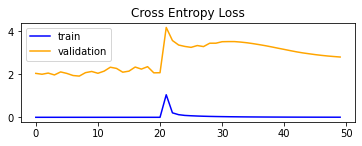

In [18]:
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(his.history['loss'], color='blue', label='train')
pyplot.plot(his.history['val_loss'], color='orange', label='test')
pyplot.legend(['train', 'validation'], loc='upper left')

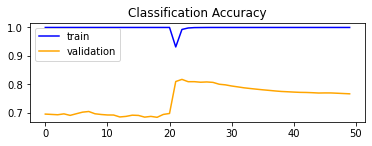

In [19]:
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(his.history['accuracy'], color='blue', label='train')
pyplot.plot(his.history['val_accuracy'], color='orange', label='test')
pyplot.legend(['train', 'validation'], loc='upper left')

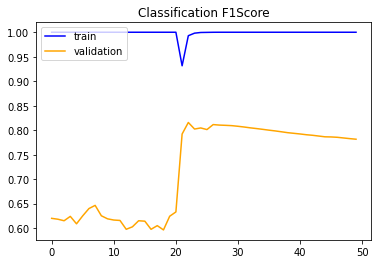

In [20]:
# plot accuracy
pyplot.subplot()
pyplot.title('Classification F1Score')
pyplot.plot(his.history['f1_score'], color='blue', label='train')
pyplot.plot(his.history['val_f1_score'], color='orange', label='test')
pyplot.legend(['train', 'validation'], loc='upper left')